In [1]:
# Libraries
import os
import copy
import time
import math
import pickle
import argparse
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# Plot parameters
plt.rcParams.update({
    'lines.linewidth': 2,               # linewidth
    'font.family': 'Helvetica Neue',    # font
    'mathtext.fontset': 'cm',           # math font
    'mathtext.default': 'it',           # math font style
    'font.size': 24,                    # font size
    'axes.titlesize': 24,               # title size
    'axes.grid': True,                  # grid
    'grid.linestyle': '-.',             # grid style
    'axes.facecolor': '#ECECEC',        # background color for the axes
    'figure.facecolor': '#FFFFFF',      # background color for the axes
    'legend.facecolor': '#FFFFFF'       # background color for the legend
})

from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from own_optimizers import Own_RAdam
from own_optimizers import Own_SGD
from lbfgsnew import LBFGSNew

In [2]:
# Global variables
Ll = 0
dim = 0
device = 0
n_class = 0

dataname = ''
used_optimizer = ''

In the following cell, we declared a class that contains different functions to load different datasets to test. All of them were normalized and transformed accordingly so the data has a dimension that is a power of $2$ to match the size of the Hilbert space $\mathbb{C}^{n}$, with $n$ being the number of qubits. We used the following datasets:
- CIFAR-10.
- CIFAR-100.
- MSL (NASA) dataset.
- MNIST.
- ImageNet.

In [ ]:
class DatasetLoader:
    class CIFARDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X.T, dtype = torch.float32)
            self.y = torch.tensor(y, dtype = torch.long)

        def __len__(self):
            return self.X.shape[0]

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]
        
    def __init__(self, name, transform = None, image_transform = None):
        self.name = name
        self.transform = transform
        self.image_transform = image_transform
        self.train_dataset = None
        self.test_dataset = None
        self.mean = None
        self.std = None
        self.load()

    def normalization_flat(self, X):
        self.mean = np.mean(X, axis = 1, keepdims = True)
        self.std  = np.std(X, axis = 1, keepdims = True)
        return self.mean, self.std

    def normalization_image(self, X):
        self.mean = np.mean(X, axis = (0, 1, 2))
        self.std  = np.std(X, axis = (0, 1, 2))
        return self.mean, self.std

    def load_batch(self, path, label):
        with open(path, 'rb') as f:
            data = pickle.load(f, encoding = 'bytes')
        X = data[b'data'].T / 255.0
        y = np.array(data[label])
        return X, y

    def dataset_size(self):
        if self.name in ['FashionMNIST', 'MNIST']:
            n_qubits = 10
            n_class = 10
        elif self.name == 'CIFAR-10':
            n_qubits = 12
            n_class = 10
        elif self.name == 'CIFAR-100':
            n_qubits = 12
            n_class = 100
        elif self.name == 'msl':
            n_qubits = 12
            n_class = 25
        elif self.name == 'ImageNet':
            n_qubits = 12
            n_class = 10
        else:
            raise ValueError(f'Dataset not used: {self.name}')

        return n_qubits, n_class

    # Dataset loading
    def load(self):
        loader = {
            'FashionMNIST': self.load_fashionmnist,
            'MNIST': self.load_mnist,
            'CIFAR-10': self.load_cifar10,
            'CIFAR-100': self.load_cifar100,
            'msl': self.load_msl,
            'ImageNet': self.load_imagenet,
        }

        if self.name not in loader:
            raise ValueError(f'Dataset not used: {self.name}')
        loader[self.name]()

    def load_fashionmnist(self):
        self.train_dataset = datasets.FashionMNIST(
            root = 'FashionMNIST', train = True, download = True, transform = self.transform)
        self.test_dataset = datasets.FashionMNIST(
            root = 'FashionMNIST', train = False, download = True, transform = self.transform)

    def load_mnist(self):
        self.train_dataset = datasets.MNIST(
            root = 'MNIST', train = True, download = True, transform = self.transform)
        self.test_dataset = datasets.MNIST(
            root = 'MNIST', train = False, download = True, transform = self.transform)

    def load_cifar10(self):
        X_train, y_train = self.load_batch('Datasets/cifar-10-batches-py/data_batch_1', b'labels')
        X_val, y_val     = self.load_batch('Datasets/cifar-10-batches-py/data_batch_2', b'labels')
        X_test, y_test   = self.load_batch('Datasets/cifar-10-batches-py/test_batch',   b'labels')
        
        self.mean, self.std = self.normalization_flat(X_train)
        X_train = (X_train - self.mean) / self.std
        X_test  = (X_test - self.mean) / self.std

        self.train_dataset = self.CIFARDataset(X_train, y_train)
        self.test_dataset  = self.CIFARDataset(X_test, y_test)

    def load_cifar100(self):
        X_train, y_train = self.load_batch('Datasets/cifar-100-python/train', b'fine_labels')
        X_test, y_test   = self.load_batch('Datasets/cifar-100-python/test',  b'fine_labels')
        
        self.mean, self.std = self.normalization_flat(X_train)
        X_train = (X_train - self.mean) / self.std
        X_test  = (X_test - self.mean) / self.std

        self.train_dataset = self.CIFARDataset(X_train, y_train)
        self.test_dataset  = self.CIFARDataset(X_test, y_test)

    def load_msl(self):
        def load_images(filename):
            basepath = 'Datasets/msl-images/calibrated/'
            df = pd.read_csv(filename, sep = ' ', header = None, names = ['filename', 'label'])
            X, y = [], []

            for _, row in df.iterrows():
                path = os.path.join(basepath, os.path.basename(row['filename']))
                img = Image.open(path).convert('RGB').resize((32, 32))
                X.append(np.array(img) / 255.0)
                y.append(int(row['label']))
            
            return np.array(X), np.array(y)

        X_train, y_train = load_images('Datasets/msl-images/train-calibrated-shuffled.txt')
        X_val, y_val     = load_images('Datasets/msl-images/val-calibrated-shuffled.txt')
        X_test, y_test   = load_images('Datasets/msl-images/test-calibrated-shuffled.txt')
        
        X_all = np.concatenate([X_train, X_val, X_test], axis = 0)
        y_all = np.concatenate([y_train, y_val, y_test], axis = 0)
        
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, stratify = y_all, random_state = 42)
        
        self.mean, self.std = self.normalization_image(X_train)
        X_train = (X_train - self.mean) / self.std
        X_test  = (X_test - self.mean) / self.std
        
        X_train = X_train.reshape(X_train.shape[0], -1).T
        X_test  = X_test.reshape(X_test.shape[0], -1).T
        
        self.train_dataset = self.CIFARDataset(X_train, y_train)
        self.test_dataset  = self.CIFARDataset(X_test, y_test)

    def load_imagenet(self):
        dataset = ImageFolder(root = 'Datasets/ImageNet', transform = self.image_transform)
        X, y = [], []
        for img, label in dataset:
            X.append(img.numpy())
            y.append(label)
        X, y = np.array(X), np.array(y)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
        X_train = X_train.reshape(X_train.shape[0], -1).T
        X_test  = X_test.reshape(X_test.shape[0], -1).T

        self.train_dataset = self.CIFARDataset(X_train, y_train)
        self.test_dataset  = self.CIFARDataset(X_test, y_test)

In the next part of the code, we declare a class that contains the hybrid quantum neural network (hQNN) architecture we used for the image classification task. This architecture has $L$ quantum layers and first applies a parametrized rotation around the $y$-axis:
$$
\mathrm{R}_{y}(\theta^{l}) = \bigotimes_{i = 1}^{n} R_{y}(\theta_{i}^{l}) = R_{y}(\theta_{1}^{l}) \otimes \cdots \otimes R_{y}(\theta_{n}^{l}),
$$

where the single-qubit rotation $R_{y}(\theta_{i})$ acts only on the $i$-th qubit and is defined as
$$
R_{y}(\theta) = \cos \left( \dfrac{\theta_{i}}{2} \right) \mathbb{1} - \mathrm{i} \sin \left( \dfrac{\theta_{i}}{2} \right) \hat{Y}.
$$

The next operation is a controlled-$\hat{X}$ gate to entangle qubit pairs,
$$
\texttt{CNOT} = \bigotimes_{(i, j)} \texttt{CNOT}_{(i, j)},
$$

where the individual operation between the control qubit $i$ and the target qubit $j$ is made with the equation
$$
\texttt{CNOT}_{(i, j)} = | 0 \rangle \langle 0 |_{i} \otimes \mathbb{1} + | 1 \rangle \langle 1 |_{j} \otimes \hat{X}_{j}.
$$

As usual, the operators we used were the following:
- $\mathbb{I}$ is the identity matrix; 
- $\hat{X}$ is the Pauli $\hat{X}$ matrix;
- $| 0 \rangle \langle 0 |$ and $| 1 \rangle \langle 1 |$ are the projector operators.

After applying the $L$ quantum layers, we obtained a probability vector from the resulting quantum state and process the result in a final classical linear layer, producing the model output $\mathcal{L}(\Theta, w | x)$. This information is used to predict the image labels.

In [4]:
def get_device(gpu_no = 0):
    return torch.device(f'cuda:{gpu_no}' if torch.cuda.is_available() else 'cpu')

class QNN(nn.Module):
    def __init__(self, n_qubits, layers, dataname, n_class, state_vector = None, device = 'cuda', gpu_no = 0):
        super().__init__()
        self.n_qubits = n_qubits
        self.dim = 2 ** n_qubits
        self.dataname = dataname
        self.device = get_device(gpu_no) if device == 'cuda' else torch.device(device)

        if state_vector is None:
            state_vector = torch.zeros(self.dim, device = self.device, dtype = torch.cfloat)
            state_vector[0] = 1
            self.state_vector = state_vector.reshape(-1, 1)
        elif state_vector.shape[0] == self.dim:
            self.state_vector = state_vector.to(device = self.device, dtype = torch.cfloat).reshape(-1, 1)
        else:
            raise ValueError(f'State vector size must match 2^{n_qubits}.')

        # Quantum gates
        self.I = torch.tensor([[1, 0], [0, 1]], device = self.device, dtype = torch.cfloat)
        self.X_mat   = torch.tensor([[0, 1], [1, 0]], device = self.device, dtype = torch.cfloat)
        self.proj_0  = torch.tensor([[1, 0], [0, 0]], device = self.device, dtype = torch.cfloat)
        self.proj_1  = torch.tensor([[0, 0], [0, 1]], device = self.device, dtype = torch.cfloat)
        self.flatten = nn.Flatten()

        angles = torch.empty((layers, n_qubits), dtype = torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)

        self.angles = torch.nn.Parameter(angles)
        self.linear = nn.Linear(2 ** n_qubits, n_class)
        
    def controlled_gate(self, control: int, target: int, gate = torch.Tensor):
        if gate is None:
            raise ValueError('Gate must be provided.')

        if control < 0 or self.n_qubits <= control:
            raise ValueError(f"Control qubit {control} is out of bounds (must be 0 ≤ qubit < {self.n_qubits}).")
        elif target < 0 or self.n_qubits <= target:
            raise ValueError(f"Target qubit {control} is out of bounds (must be 0 ≤ qubit < {self.n_qubits}).")
        elif control == target:
            raise ValueError(f'Control and target qubits must differ.')
        else:
            control_gate_0 = torch.tensor(1.0, device = self.device, dtype = torch.cfloat)
            control_gate_1 = torch.tensor(1.0, device = self.device, dtype = torch.cfloat)

            for k in range(self.n_qubits):
                if k == control:
                    control_gate_0 = torch.kron(control_gate_0, self.proj_0)
                    control_gate_1 = torch.kron(control_gate_1, self.proj_1)
                elif k == target:
                    control_gate_0 = torch.kron(control_gate_0, self.I)
                    control_gate_1 = torch.kron(control_gate_1, gate)
                else:
                    control_gate_0 = torch.kron(control_gate_0, self.I)
                    control_gate_1 = torch.kron(control_gate_1, self.I)
            
            control_gate = control_gate_0 + control_gate_1
            self.state_vector = torch.matmul(control_gate, self.state_vector)
            return self.state_vector

    def Ry_layer(self, angle: torch.Tensor):
        cos, sin = torch.cos(angle[0]), torch.sin(angle[0])
        rot = torch.stack([torch.stack([cos, -sin]), torch.stack([sin, cos])])
        
        for i in range(1, len(angle)):      
            cos, sin = torch.cos(angle[i]), torch.sin(angle[i])
            rot = torch.kron(rot, torch.stack([torch.stack([cos, -sin]), torch.stack([sin, cos])])) 
        
        self.state_vector = torch.matmul(rot, self.state_vector)
        return self.state_vector

    def cx_linear_layer(self):
        self.controlled_gate(self.n_qubits - 2, self.n_qubits - 1, self.X_mat)
        for i in range(self.n_qubits - 3, -1, -1):
            self.controlled_gate(i, i + 1, self.X_mat)

    def probabilities(self):
        return self.state_vector.conj() * self.state_vector

    def forward(self, x):
        if self.dataname in ['FashionMNIST', 'MNIST']:
            x = F.pad(x, (2, 2, 2, 2), 'constant', 0)
            x = self.flatten(x)
            x /= torch.linalg.norm(x, ord = 2, dim = 1, keepdim = True)
        elif self.dataname in ['CIFAR-10', 'CIFAR-100', 'msl', 'ImageNet']:
            x = F.pad(x, (0, 2 ** self.n_qubits - x.shape[1]), 'constant', 0)
            x = self.flatten(x)
            x /= torch.linalg.norm(x, ord = 2, dim = 1, keepdim = True)
        
        self.state_vector = x.T.to(torch.cfloat)

        for l in range(self.angles.shape[0]):
            self.Ry_layer(self.angles[l].to(torch.cfloat))
            self.cx_linear_layer()

        x = torch.real(self.probabilities())
        return self.linear(x.T)

Next, we defined a class that provides all the functions needed for the training of the model, including the performance evaluation.

In [13]:
class Training:
    def __init__(self, dataset, test_dataset, batch_size, n_qubits, layers, dataname, n_class,
                 optimizer_name, learn_rate, weight_decay, device = 'cuda', gpu_no = 0):
        self.dataset        = dataset
        self.test_dataset   = test_dataset
        self.batch_size     = batch_size
        self.n_qubits       = n_qubits
        self.layers         = layers
        self.dataname       = dataname
        self.n_class        = n_class
        self.optimizer_name = optimizer_name
        self.learn_rate     = learn_rate
        self.weight_decay   = weight_decay
        self.device         = torch.device(f'cuda:{gpu_no}' if torch.cuda.is_available() and device == 'cuda' else 'cpu')
        
        # Initialize model and training tools
        self.model = QNN(
            n_qubits = self.n_qubits,
            layers   = self.layers,
            dataname = self.dataname,
            n_class  = self.n_class,
            device   = self.device
        ).to(self.device)
        
        self.loss_fn = self.get_loss()
        self.optimizer = self.get_optimizer()

    def get_loss(self):
        try:
            y_train = self.dataset.dataset.y[self.dataset.indices].cpu().numpy()
            classes_in_y = np.unique(y_train)
            weights = compute_class_weight('balanced', classes = classes_in_y, y = y_train)
            full_weights = np.zeros(self.n_class, dtype = np.float32)

            for cls, w in zip(classes_in_y, weights):
                full_weights[int(cls)] = w
            return nn.CrossEntropyLoss(weight = torch.tensor(full_weights, dtype = torch.float32).to(self.device))
        
        except:
            return nn.CrossEntropyLoss()

    def get_optimizer(self):
        print(f'Optimizer: {self.optimizer_name}\n')
        if self.optimizer_name == 'RAdam':
            return Own_RAdam(self.model.parameters(), learn_rate = self.learn_rate, lam = self.weight_decay)
        elif self.optimizer_name == 'SGD':
            return Own_SGD(self.model.parameters(), learn_rate = self.learn_rate, lam = self.weight_decay, momentum = 0)
        elif self.optimizer_name == 'LBFGS':
            return LBFGSNew(self.model.parameters(), history_size = 50, max_iter = 4, line_search_fn = True, batch_mode = True)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')

    def performance_estimate(self, dataset, stage = 'train'):
        data_size = len(dataset)
        dataloader = DataLoader(dataset, batch_size = self.batch_size, shuffle = True)
        n_batches = len(dataloader)

        self.model.eval()
        loss, accuracy = 0, 0

        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                accuracy += (pred.argmax(1) == y).sum().item()
                loss += self.loss_fn(pred, y).item()

        loss     /= n_batches
        accuracy /= data_size
        print(f"{stage.capitalize()} accuracy: {round(accuracy, 3)} | {stage} loss: {round(loss, 3)}")
        return accuracy, loss

    def one_epoch(self, plot_info, epoch_index):
        dataloader = DataLoader(
            dataset    = self.dataset,
            batch_size = self.batch_size,
            shuffle    = True,
            drop_last  = True
        )
        offset = (len(self.dataset) // self.batch_size) * epoch_index

        self.model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(self.device), y.to(self.device)

            if isinstance(self.optimizer, LBFGSNew):
                def closure():
                    if torch.is_grad_enabled():
                        self.optimizer.zero_grad()
                    out  = self.model(X)
                    loss = self.loss_fn(out, y)
                    if loss.requires_grad:
                        loss.backward()
                    return loss
                self.optimizer.step(closure)
            else:
                self.optimizer.zero_grad()
                out  = self.model(X)
                loss = self.loss_fn(out, y)
                loss.backward()
                self.optimizer.step()

            step = batch + offset
            if step in plot_info['inds_map']:
                k = plot_info['inds_map'][step]
                accuracy_train, loss_train = self.performance_estimate(self.dataset, 'train')
                accuracy_test, loss_test   = self.performance_estimate(self.test_dataset, 'test')
                plot_info['ATr'][k] = accuracy_train
                plot_info['LTr'][k] = loss_train
                plot_info['AVa'][k] = accuracy_test
                plot_info['LVa'][k] = loss_test

    def train(self, epochs):
        total_prints = 5 * epochs
        plot_info = {
            'inds': np.unique(np.linspace(
                0, (int(len(self.dataset)) // self.batch_size) * epochs - 1,
                num = total_prints, dtype = int
            )),
            'inds_map': {},
            'LTr': np.zeros(total_prints),
            'LVa': np.zeros(total_prints),
            'ATr': np.zeros(total_prints),
            'AVa': np.zeros(total_prints)
        }
        plot_info['inds_map'] = {v: i for i, v in enumerate(plot_info['inds'])}

        for t in range(epochs):
            print(f'Epoch {t + 1} ===============')
            self.one_epoch(plot_info, t)

        model_state_dict = self.model.state_dict()
        return plot_info, model_state_dict

def plot_results(plot_info, model_state_dict, test_dataset, 
                 model_class, dataname, device, n_qubits, layers, n_class):
    accuracy_train, loss_train = plot_info['ATr'], plot_info['LTr']
    accuracy_test, loss_test   = plot_info['AVa'], plot_info['LVa']
    steps = plot_info['inds']

    print(f'\nPlotting results and predicting random test sample.\n')

    # Load trained model
    model = model_class(n_qubits = n_qubits, layers = layers, dataname = dataname, n_class = n_class, device = device).to(device)
    model.load_state_dict(model_state_dict)

    # Pick a random test sample
    idx = np.random.choice(len(test_dataset))
    x = test_dataset[idx][0]
    x = x.unsqueeze(0).to(device)

    out_ = model(x).detach().flatten()
    prob = F.softmax(out_, dim = 0)
    pred = prob.argmax().item()

    print(f'True label: {test_dataset[idx][1]}')
    print(f'Predicted label: {pred}')

    # --- Combined Plot ---
    plt.figure(figsize = (18, 6))
    
    plt.subplot(1, 3, 1)
    plt.stem(np.arange(n_class), prob.cpu().numpy())
    plt.title('Probability of the predicted classes')
    plt.ylabel('Probability')
    plt.xlabel('Class labels')

    plt.subplot(1, 3, 2)
    plt.plot(steps, accuracy_train, label = 'Train set', color = '#D40000')
    plt.plot(steps, accuracy_test, label = 'Test set', color = '#0000FF')
    plt.title('Accuracy across updates')
    plt.ylabel('Accuracy')
    plt.xlabel('Steps')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(steps, loss_train, label = 'Train set', color = '#D40000')
    plt.plot(steps, loss_test, label = 'Test set', color = '#0000FF')
    plt.title('Loss across updates')
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.legend()

    plt.tight_layout()

In [6]:
def main():
    dataset_options = ["MNIST", "FashionMNIST", "CIFAR-10", "CIFAR-100", "msl", "ImageNet"]
    optimizer_options = ["SGD", "RAdam", "LBFGS"]

    print("Available datasets:", ", ".join(dataset_options))
    dataname = input("-Enter dataset name: ").strip()

    while dataname not in dataset_options:
        print("Invalid dataset. Please choose from:", ", ".join(dataset_options))
        dataname = input("-Enter dataset name: ").strip()

    print("Available optimizers:", ", ".join(optimizer_options))
    optimizer_name = input("-Enter optimizer name: ").strip()

    while optimizer_name not in optimizer_options:
        print("Invalid optimizer. Please choose from:", ", ".join(optimizer_options))
        optimizer_name = input("Enter optimizer name: ").strip()

    try:
        epochs = int(input("-Enter number of training epochs [default = 1]: ") or 1)
    except ValueError:
        print("Invalid number. Using default: 1")
        epochs = 1

    if torch.cuda.is_available():
        print(f'-CUDA available: {torch.cuda.is_available()} — {torch.cuda.get_device_name(0)}')
        device = 'cuda'
        gpu_no = 0
    else:
        device = 'cpu'
    print(f"-Using device: {device}")

    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean = (0.5, ), std = (0.5, ))
    ])
    image_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ])

    dataloader    = DatasetLoader(name = dataname, transform = transform, image_transform = image_transform)
    train_dataset = dataloader.train_dataset
    test_dataset  = dataloader.test_dataset
    print(f'Train/test split: {len(train_dataset)}, {len(test_dataset)}')

    n_qubits, n_class = dataloader.dataset_size()
    print(f'\n-Number of qubits: {n_qubits}')
    print(f'-Number of classes: {n_class}')
    layers = 3
    print(f'-Quantum layers (L): {layers}')
    print(f'-Total quantum angles: {n_qubits * layers}')

    batch_size = 64
    learn_rate = 1e-1
    weight_decay = 1e-10

    trainer = Training(dataset = train_dataset, test_dataset = test_dataset, batch_size = batch_size,
                       n_qubits = n_qubits, layers = layers, dataname = dataname, n_class = n_class, 
                       optimizer_name = optimizer_name, learn_rate = learn_rate, 
                       weight_decay = weight_decay, device = device, gpu_no = gpu_no)
    
    plot_info, model_state_dict = trainer.train(epochs)

    model_path = f"model_{dataname}_QNN.pth"
    torch.save(model_state_dict, model_path)
    print(f'\nTraining complete. Model saved to {model_path}')

    plot_results(
        plot_info        = plot_info,
        model_state_dict = model_state_dict,
        test_dataset     = test_dataset,
        model_class      = QNN,
        dataname         = dataname,
        device           = device,
        n_qubits         = n_qubits,
        layers           = layers,
        n_class          = n_class
    )
    plt.show()

Available datasets: MNIST, FashionMNIST, CIFAR-10, CIFAR-100, msl, ImageNet
Available optimizers: SGD, RAdam, LBFGS
-CUDA available: True — NVIDIA GeForce RTX 3070 Laptop GPU
-Using device: cuda
Train/test split: 60000, 10000

-Number of qubits: 10
-Number of classes: 10
-Quantum layers (L): 3
-Total quantum angles: 30
Optimizer: RAdam

Epoch 1 ===============
Train accuracy: 0.099 | train loss: 2.303
Test accuracy: 0.103 | test loss: 2.303
Train accuracy: 0.73 | train loss: 1.586
Test accuracy: 0.747 | test loss: 1.57
Train accuracy: 0.818 | train loss: 1.011
Test accuracy: 0.832 | test loss: 0.992
Train accuracy: 0.857 | train loss: 0.74
Test accuracy: 0.868 | test loss: 0.715
Train accuracy: 0.869 | train loss: 0.592
Test accuracy: 0.878 | test loss: 0.57
Epoch 2 ===============
Train accuracy: 0.881 | train loss: 0.551
Test accuracy: 0.887 | test loss: 0.527
Train accuracy: 0.885 | train loss: 0.461
Test accuracy: 0.893 | test loss: 0.442
Train accuracy: 0.899 | train loss: 0.409
T

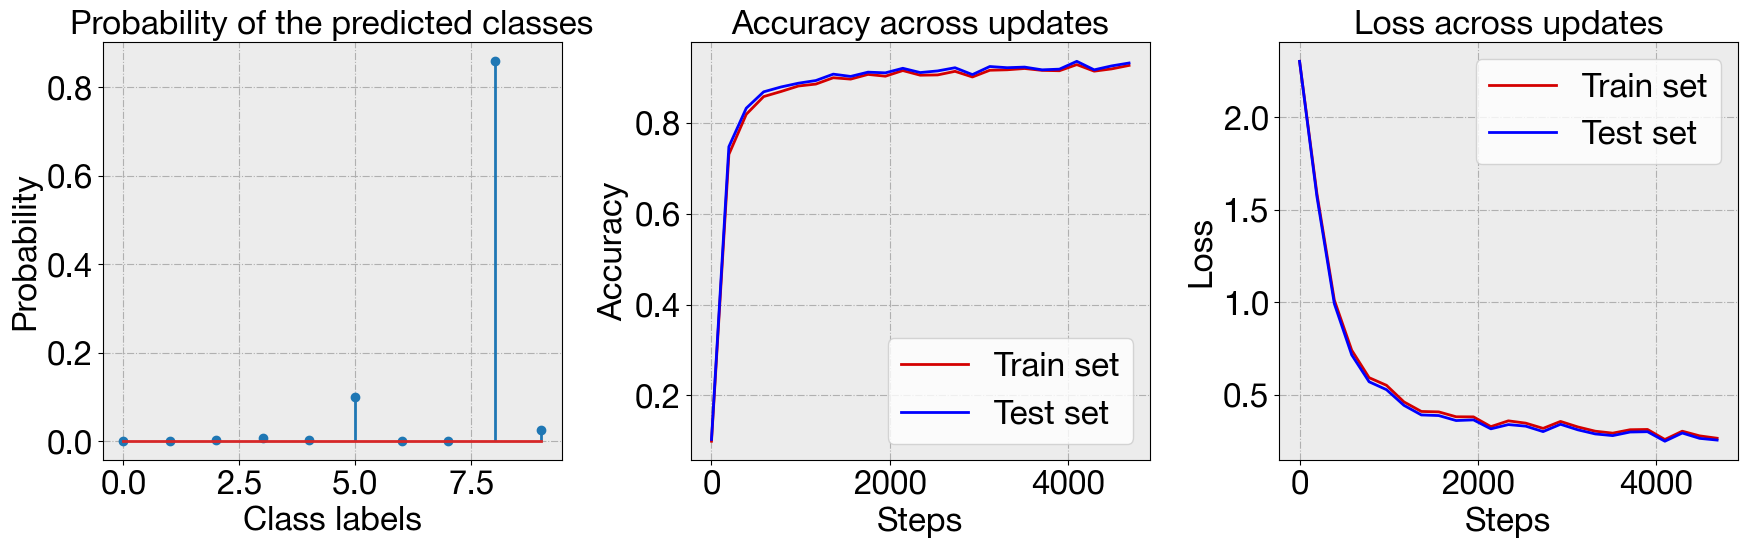

In [15]:
main()

Available datasets: MNIST, FashionMNIST, CIFAR-10, CIFAR-100, msl, ImageNet
Available optimizers: SGD, RAdam, LBFGS
-CUDA available: True — NVIDIA GeForce RTX 3070 Laptop GPU
-Using device: cuda
Train/test split: 60000, 10000

-Number of qubits: 10
-Number of classes: 10
-Quantum layers (L): 3
-Total quantum angles: 30
Optimizer: LBFGS

Epoch 1 ===============
Train accuracy: 0.104 | train loss: 2.325
Test accuracy: 0.103 | test loss: 2.325
Train accuracy: 0.712 | train loss: 0.889
Test accuracy: 0.721 | test loss: 0.871
Train accuracy: 0.684 | train loss: 0.962
Test accuracy: 0.683 | test loss: 0.96
Train accuracy: 0.729 | train loss: 0.837
Test accuracy: 0.741 | test loss: 0.803
Train accuracy: 0.719 | train loss: 0.85
Test accuracy: 0.727 | test loss: 0.841
Epoch 2 ===============
Train accuracy: 0.721 | train loss: 0.886
Test accuracy: 0.727 | test loss: 0.863
Train accuracy: 0.735 | train loss: 0.824
Test accuracy: 0.741 | test loss: 0.796
Train accuracy: 0.72 | train loss: 0.849


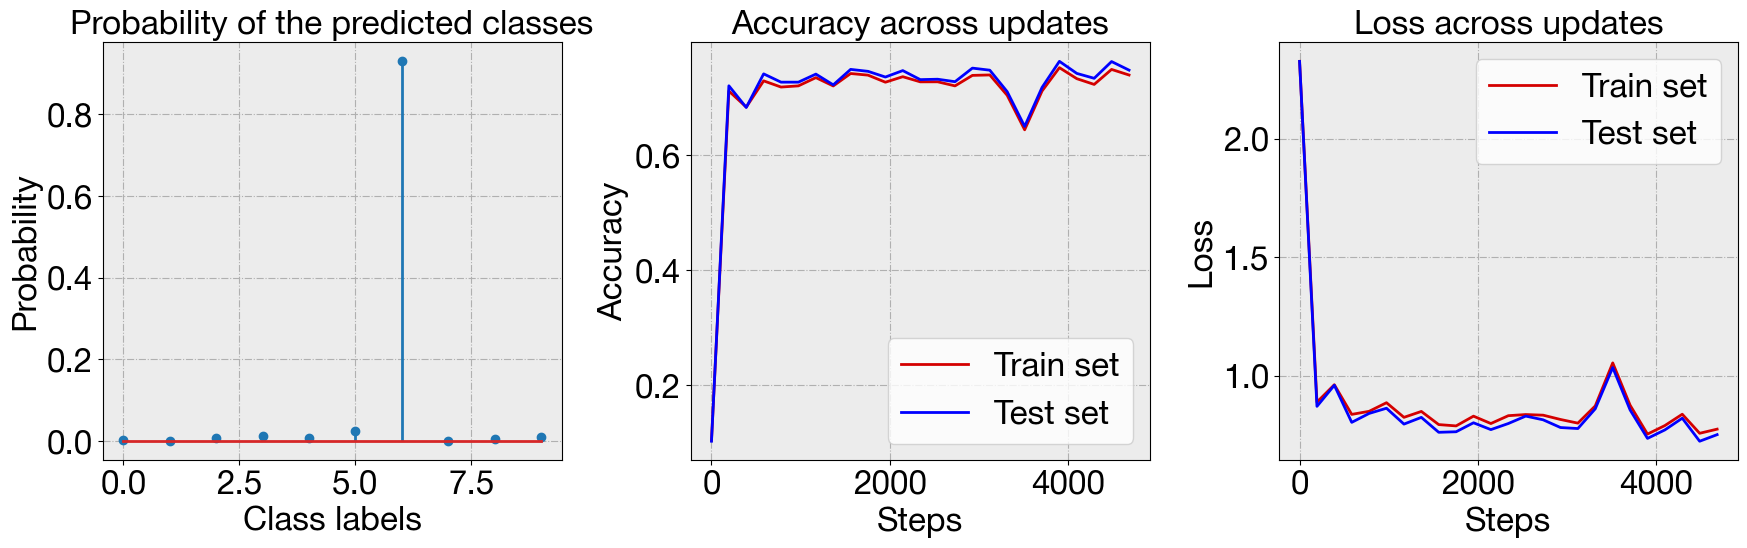

In [16]:
main()

Available datasets: MNIST, FashionMNIST, CIFAR-10, CIFAR-100, msl, ImageNet
Available optimizers: SGD, RAdam, LBFGS
-CUDA available: True — NVIDIA GeForce RTX 3070 Laptop GPU
-Using device: cuda
Train/test split: 10400, 2600

-Number of qubits: 12
-Number of classes: 10
-Quantum layers (L): 3
-Total quantum angles: 36
Optimizer: RAdam

Epoch 1 ===============
Train accuracy: 0.1 | train loss: 2.303
Test accuracy: 0.1 | test loss: 2.303
Train accuracy: 0.141 | train loss: 2.284
Test accuracy: 0.14 | test loss: 2.285
Train accuracy: 0.226 | train loss: 2.213
Test accuracy: 0.222 | test loss: 2.22
Train accuracy: 0.266 | train loss: 2.128
Test accuracy: 0.267 | test loss: 2.14
Train accuracy: 0.271 | train loss: 2.076
Test accuracy: 0.261 | test loss: 2.092
Epoch 2 ===============
Train accuracy: 0.313 | train loss: 2.031
Test accuracy: 0.297 | test loss: 2.053
Train accuracy: 0.307 | train loss: 1.996
Test accuracy: 0.295 | test loss: 2.017
Train accuracy: 0.352 | train loss: 1.965
Test 

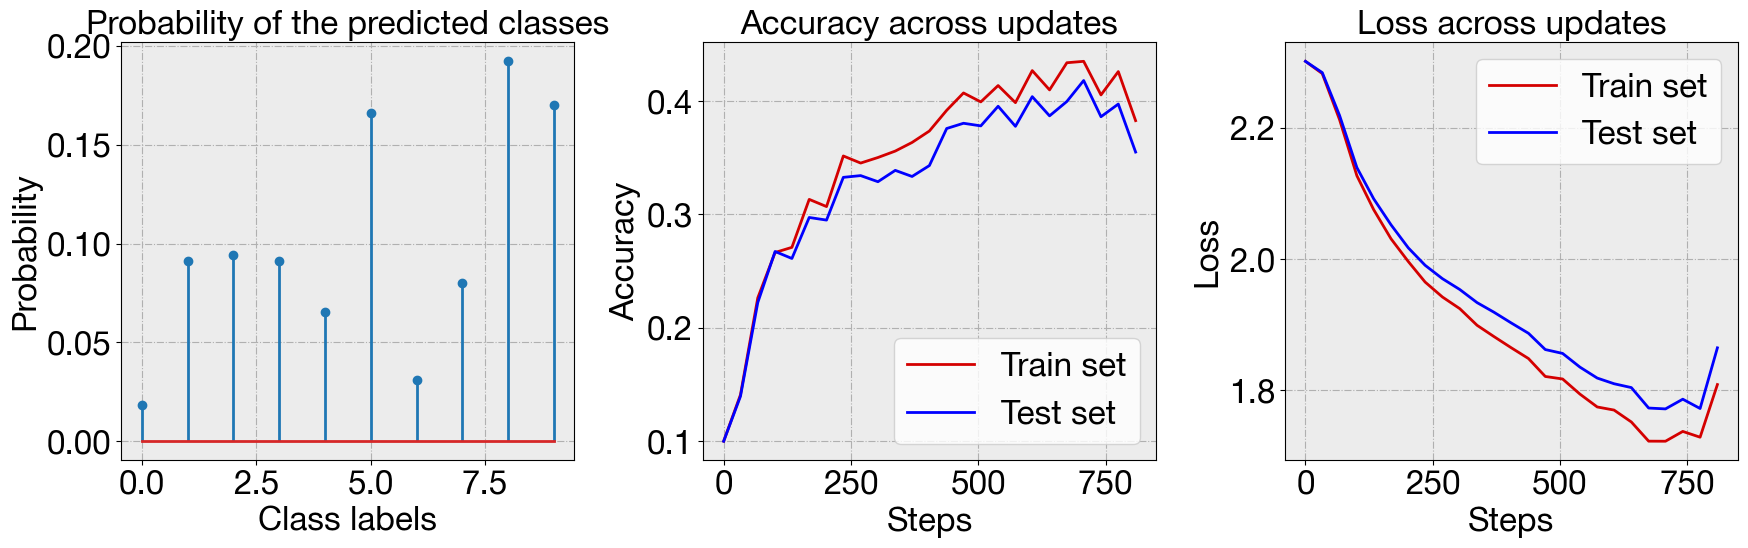

In [18]:
main()

Available datasets: MNIST, FashionMNIST, CIFAR-10, CIFAR-100, msl, ImageNet
Available optimizers: SGD, RAdam, LBFGS
-CUDA available: True — NVIDIA GeForce RTX 3070 Laptop GPU
-Using device: cuda
Train/test split: 10400, 2600

-Number of qubits: 12
-Number of classes: 10
-Quantum layers (L): 3
-Total quantum angles: 36
Optimizer: LBFGS

Epoch 1 ===============
Train accuracy: 0.12 | train loss: 2.377
Test accuracy: 0.11 | test loss: 2.377
Train accuracy: 0.1 | train loss: 2.362
Test accuracy: 0.1 | test loss: 2.362
Train accuracy: 0.1 | train loss: 2.36
Test accuracy: 0.1 | test loss: 2.359
Train accuracy: 0.1 | train loss: 2.353
Test accuracy: 0.1 | test loss: 2.352
Train accuracy: 0.1 | train loss: 2.374
Test accuracy: 0.1 | test loss: 2.374
Epoch 2 ===============
Train accuracy: 0.1 | train loss: 2.419
Test accuracy: 0.1 | test loss: 2.418
Train accuracy: 0.1 | train loss: 2.364
Test accuracy: 0.099 | test loss: 2.364
Train accuracy: 0.1 | train loss: 2.446
Test accuracy: 0.1 | test

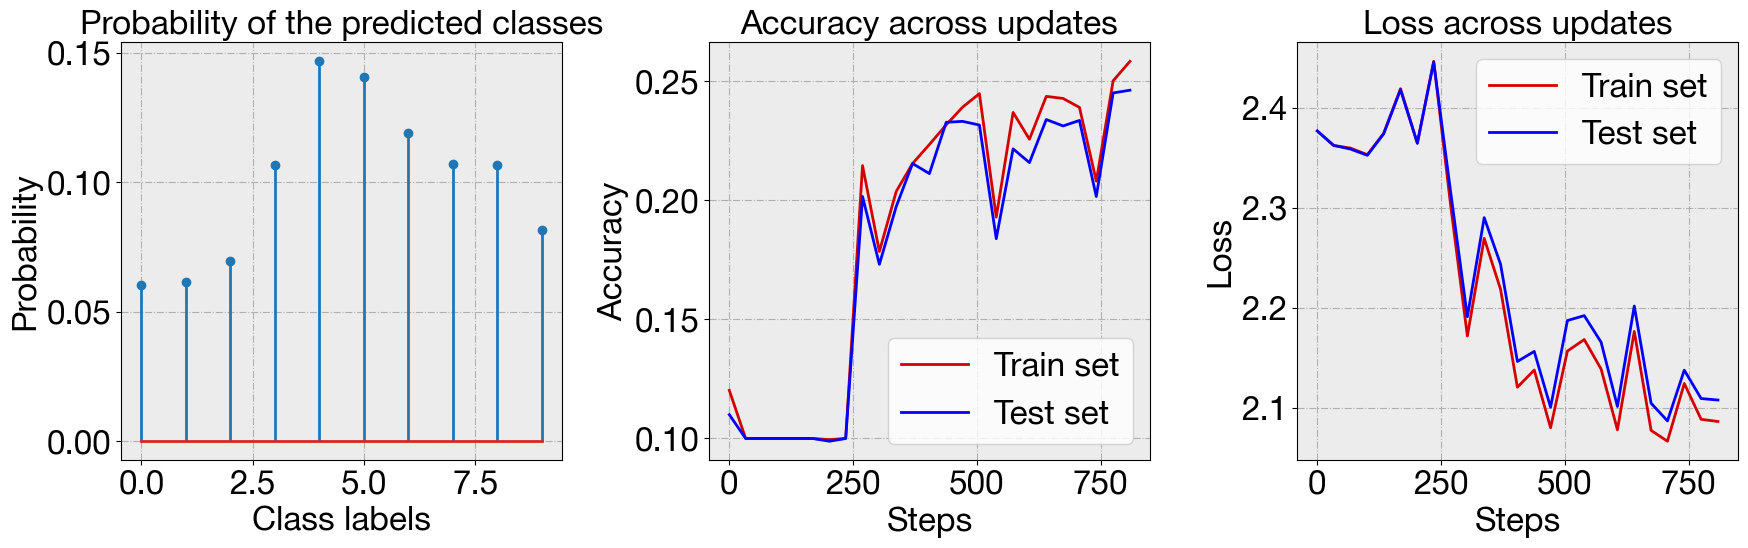

In [20]:
main()

Available datasets: MNIST, FashionMNIST, CIFAR-10, CIFAR-100, msl, ImageNet
Available optimizers: SGD, RAdam, LBFGS
-CUDA available: True — NVIDIA GeForce RTX 3070 Laptop GPU
-Using device: cuda
Train/test split: 5352, 1339

-Number of qubits: 12
-Number of classes: 25
-Quantum layers (L): 3
-Total quantum angles: 36
Optimizer: RAdam

Epoch 1 ===============
Train accuracy: 0.401 | train loss: 3.201
Test accuracy: 0.401 | test loss: 3.201
Train accuracy: 0.401 | train loss: 3.033
Test accuracy: 0.401 | test loss: 3.033
Train accuracy: 0.401 | train loss: 2.743
Test accuracy: 0.401 | test loss: 2.743
Train accuracy: 0.401 | train loss: 2.436
Test accuracy: 0.401 | test loss: 2.437
Train accuracy: 0.401 | train loss: 2.224
Test accuracy: 0.401 | test loss: 2.225
Epoch 2 ===============
Train accuracy: 0.401 | train loss: 2.126
Test accuracy: 0.401 | test loss: 2.127
Train accuracy: 0.401 | train loss: 2.05
Test accuracy: 0.401 | test loss: 2.055
Train accuracy: 0.418 | train loss: 1.983


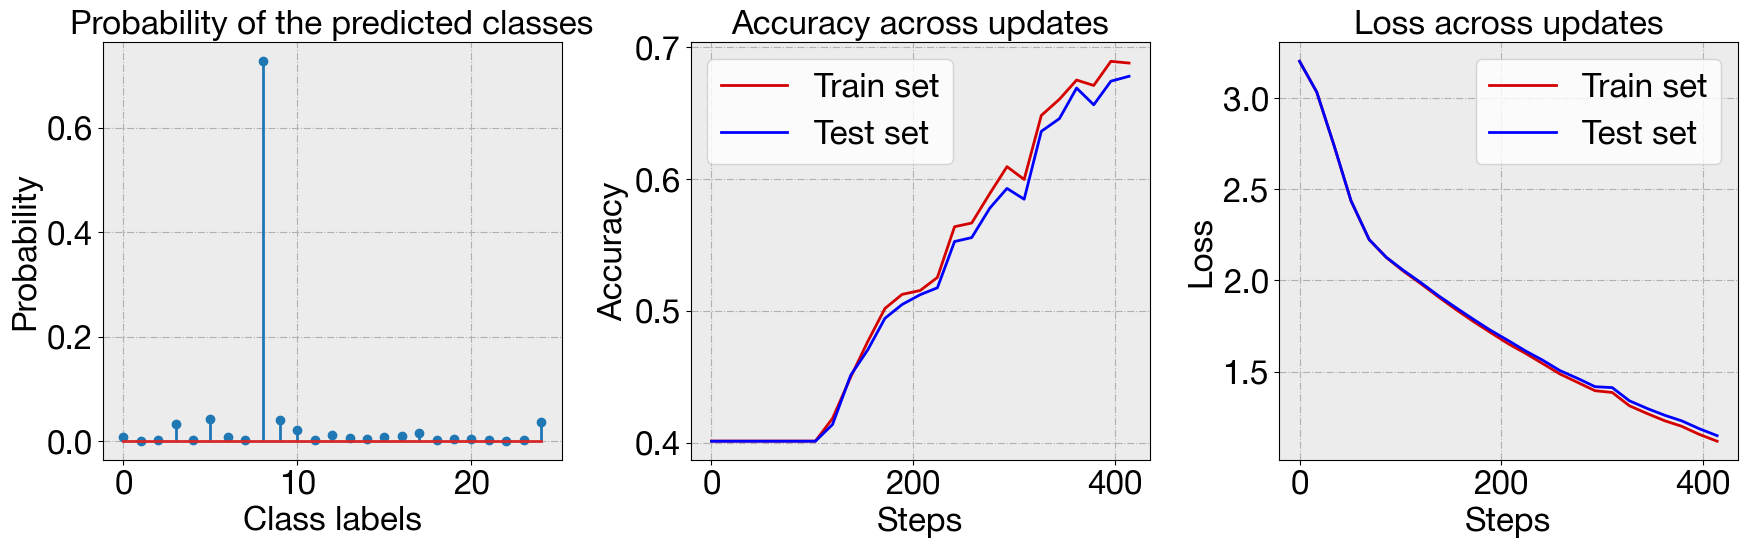

In [19]:
main()